필요 패키지 임포트

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dropout, MaxPool2D, Dense, Conv2D, Flatten, BatchNormalization,GlobalAveragePooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.mobilenet import MobileNet
from sklearn.metrics import confusion_matrix,classification_report

from skimage.transform import resize
import cv2

from tqdm import tqdm
import gc

데이터 로딩

In [ ]:
alexnet_img_size = (227,227,3)
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()

no_of_images = 2000

x_train = x_train[:no_of_images]
y_train = y_train[:no_of_images]
x_test = x_test[:int(no_of_images/2)]
y_test = y_test[:int(no_of_images/2)]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


데이터 크기 출력

In [ ]:
# Shape of Dataset
test_shape = np.shape(x_test)
train_shape = np.shape(x_train)

print(f'Shape of Test Data : {test_shape}')
print(f'Shape of Train Data : {train_shape}')

Shape of Test Data : (1000, 28, 28)
Shape of Train Data : (2000, 28, 28)


데이터 시각화해보기

Text(0.5, 1.0, 'Digit : 4')

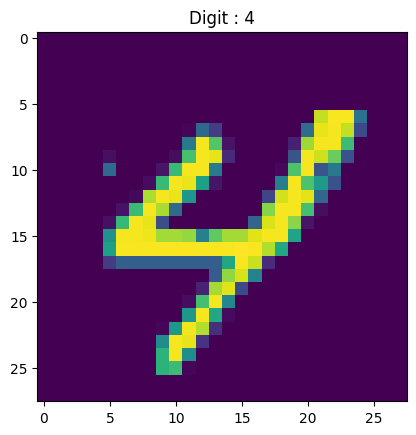

In [ ]:
n = np.random.randint(0,train_shape[0]) # Generating Random Number
sample = x_train[n]

plt.imshow(sample)
plt.title('Digit : ' + str(y_train[n]))

이미지 크기 조정함수 정의

In [ ]:
def resize_images(images,img_size):
    resized_images = []

    for i in tqdm(range(len(images))):
        img = cv2.cvtColor(images[i], cv2.COLOR_GRAY2RGB)
        resized_images.append(resize(img,(img_size),mode = 'constant'))

    return np.array(resized_images,dtype='float32')

In [ ]:
print('Loading train data for AlexNet :')
alex_train = resize_images(x_train,alexnet_img_size)

print('Loading test data for AlexNet :')
alex_test = resize_images(x_test,alexnet_img_size)

Loading train data for AlexNet :


100%|██████████| 2000/2000 [00:33<00:00, 60.44it/s]


Loading test data for AlexNet :


100%|██████████| 1000/1000 [00:14<00:00, 66.80it/s]


데이터 셔플 및 검증 데이터 분

In [ ]:
alex_train, alex_train_labels = shuffle(alex_train, y_train, random_state=10)

alex_val, alex_val_labels = alex_train[:int(no_of_images/5)], alex_train_labels[:int(no_of_images/5)]

Text(0.5, 1.0, 'Digit : 4')

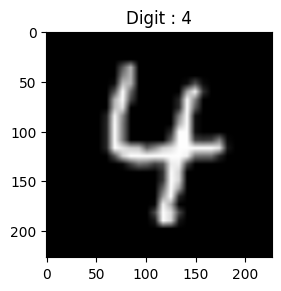

In [ ]:
alex_sample = alex_train[n]
plt.subplot(1,2,1)
plt.imshow(alex_sample)
plt.title('Digit : ' + str(alex_train_labels[n]))

AlexNet 모델 정의

In [16]:
AlexNet = Sequential()

AlexNet.add(Conv2D(filters = 96, kernel_size = (11,11), strides = (4,4), activation = 'relu', input_shape = (alexnet_img_size)))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPool2D(pool_size = (3,3), strides = (2,2)))

AlexNet.add(Conv2D(filters = 256, kernel_size = (5,5), strides = (1,1), activation = 'relu', padding = 'same'))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPool2D(pool_size = (3,3), strides = (2,2)))

AlexNet.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'same'))
AlexNet.add(BatchNormalization())

AlexNet.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'same'))
AlexNet.add(BatchNormalization())

AlexNet.add(Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'same'))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPool2D(pool_size = (3,3), strides = (2,2)))

AlexNet.add(Flatten())

AlexNet.add(Dense(units = 4096, activation = 'relu'))
AlexNet.add(Dropout(0.5))

AlexNet.add(Dense(units = 4096, activation = 'relu'))
AlexNet.add(Dropout(0.5))

AlexNet.add(Dense(units = 10, activation = 'softmax'))

early_stopping = EarlyStopping(min_delta = 0.001,patience = 40,restore_best_weights = True,verbose = 0)

# Compile
AlexNet.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

# Train
Alex = AlexNet.fit(alex_train, alex_train_labels, batch_size = 256, epochs = 50,callbacks = [early_stopping],validation_data=(alex_val, alex_val_labels))

AlexNet.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1348 - loss: 39.5180 - val_accuracy: 0.1650 - val_loss: 182.5996
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 399ms/step - accuracy: 0.2346 - loss: 2.5329 - val_accuracy: 0.1025 - val_loss: 151.5628
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 371ms/step - accuracy: 0.5031 - loss: 1.4500 - val_accuracy: 0.1450 - val_loss: 67.3404
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - accuracy: 0.6412 - loss: 0.9917 - val_accuracy: 0.2550 - val_loss: 20.7954
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - accuracy: 0.7770 - loss: 0.6957 - val_accuracy: 0.2900 - val_loss: 9.2755
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.8237 - loss: 0.5547 - val_accuracy: 0.3375 - val_loss: 5.8599
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 358ms/step - accuracy: 0.8723 - loss: 0.4161 - val_accuracy: 0.3025 - val_loss: 5.4988
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step - accuracy: 0.8664 - loss: 0.4435 - val_accuracy: 0.2725 - val_

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 55, 55, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 27, 27, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          40,9

 Total params: 174,977,952 (667.49 MB)

 Trainable params: 58,325,066 (222.49 MB)

 Non-trainable params: 2,752 (10.75 KB)

 Optimizer params: 116,650,134 (444.98 MB)

In [17]:
AlexNet_predictions = AlexNet.predict(alex_test)
AlexNet_predictions = np.argmax(AlexNet_predictions,axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


Text(0.5, 1.0, 'AlexNet Prediction \n Digit : 3')

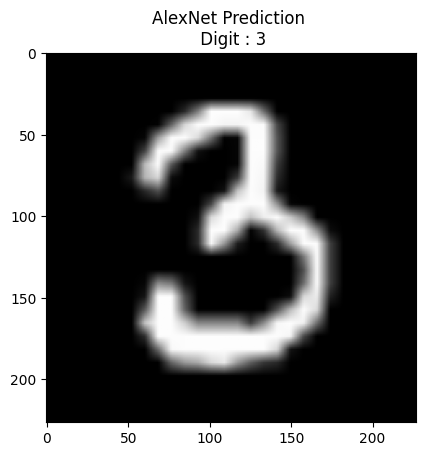

In [19]:
n = np.random.randint(0,test_shape[0]) # Generating Random Number
alex_sample = alex_test[n]

plt.subplot(1,1,1)
plt.imshow(alex_sample)
plt.title('AlexNet Prediction \n Digit : ' + str(AlexNet_predictions[n]))

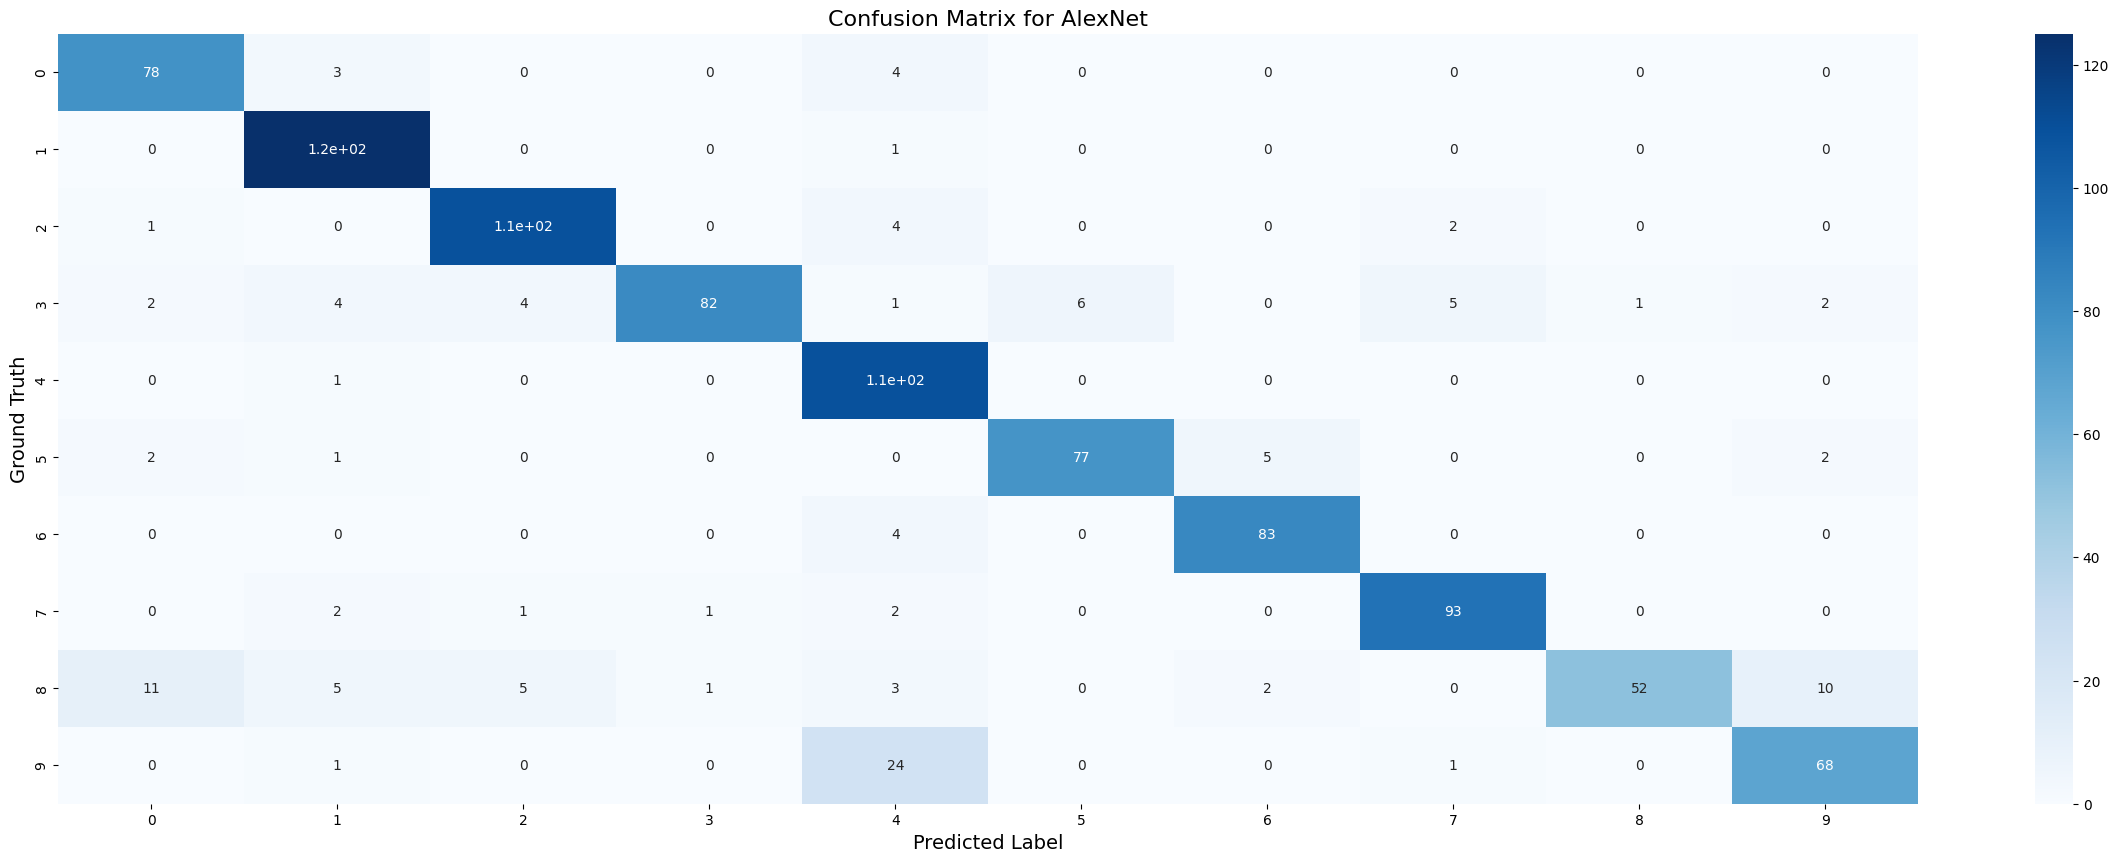

In [21]:
alex_cm = confusion_matrix(y_test, AlexNet_predictions)

class_names = np.unique(y_train)

plt.figure(figsize = (30,10))

plt.subplot(1,1,1)
sns.heatmap(alex_cm,cmap = 'Blues',annot = True, xticklabels = class_names, yticklabels = class_names)

plt.xlabel("Ground Truth", fontsize=14)
plt.ylabel("Predicted Label", fontsize=14)
plt.title("Confusion Matrix for AlexNet", fontsize=16)
plt.show()

In [24]:
def precision(cm):
    p = {}

    for i in range(len(cm)):
        p[i] = cm[i,i] / sum(cm[:,i])

    return p

def recall(cm):
    r = {}

    for i in range(len(cm)):
        r[i] = cm[i,i]/sum(cm[i,:])

    return r

def f1_score(cm):
    f1 = {}

    for i in range(len(cm)):
        f1[i] = 2 * (cm[i,i] / sum(cm[:,i])) * (cm[i,i]/sum(cm[i,:])) / ((cm[i,i] / sum(cm[:,i])) + (cm[i,i]/sum(cm[i,:])))

    return f1

In [25]:
alex_p = precision(alex_cm)  # 각 클래스별 Precision(정밀도) 계산
alex_r = recall(alex_cm)  # 각 클래스별 Recall(재현율) 계산
alex_f1 = f1_score(alex_cm)

In [31]:
Precision = {
    'Alex Precision' : alex_p,
}

Precision = pd.DataFrame(Precision)
Precision

,Alex Recall
0,0.917647
1,0.992063
2,0.939655
3,0.766355
4,0.990909
5,0.885057
6,0.954023
7,0.939394
8,0.584270
9,0.723404


In [30]:
Recall = {
    'Alex Recall' : alex_r,
}

Recall = pd.DataFrame(Recall)
Recall

,Alex Recall
0,0.917647
1,0.992063
2,0.939655
3,0.766355
4,0.990909
5,0.885057
6,0.954023
7,0.939394
8,0.584270
9,0.723404


In [28]:
F1_score = {
    'Alex F1 Score' : alex_f1,
}

F1_score = pd.DataFrame(F1_score)
F1_score

,Alex F1 Score
0,0.871508
1,0.932836
2,0.927660
3,0.858639
4,0.832061
5,0.905882
6,0.937853
7,0.930000
8,0.732394
9,0.772727
